In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from joblib import dump, load

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import spacy
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, recall_score, precision_score
from sklearn.metrics import classification_report

In [4]:
# Function for constructing confusion matrix
# model is the name of the classifier to be used

def plot_confusion_matrix(model, X_train, X_test, y_train, y_test):
    fig, axes = plt.subplots(1, 2, figsize=(16,7))
    # Block to evaluate training data
    yhat_test = model.predict(X_test)
    #yhat_test = np.argmax(yhat_test, axis=1)
    y_label_test = y_test

    mat = confusion_matrix(y_label_test, yhat_test)
    df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                      columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])
    
    sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[0]).set_title('Test Data');
    
    # Block to evaluate test data
    yhat_train = model.predict(X_train)
    y_label_train = y_train

    mat = confusion_matrix(y_label_train, yhat_train)
    df = pd.DataFrame(mat, index = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"],
                      columns = ["AfD", "Union", "FDP", "Grüne", "Linke", "SPD"])
    
    sn.heatmap(df, annot=True ,cmap='Blues', fmt='g', ax=axes[1]).set_title('Train Data');
    plt.show()
    print('Party: \t Test \t Train\nAfd:\t',sum(y_label_test == 0), "\t" , sum(y_label_train == 0))
    print('Union:\t',sum(y_label_test == 1), "\t" , sum(y_label_train == 1))
    print('FDP:\t',sum(y_label_test == 2), "\t" , sum(y_label_train == 2))
    print('Grüne:\t',sum(y_label_test == 3), "\t" , sum(y_label_train == 3))
    print('Linke:\t',sum(y_label_test == 4), "\t" , sum(y_label_train == 4))
    print('SPD:\t',sum(y_label_test == 5), "\t" , sum(y_label_train == 5))
    # Accuracy for test and train data
    print('\nAcc:\t', "{:2.2f}%".format(accuracy_score(y_label_test,yhat_test)*100), "{:2.2f}%".format(accuracy_score(y_label_train,yhat_train)*100))
    print("\n"+classification_report(y_label_test, yhat_test,  digits=4)) 

In [5]:
# make_pipeline () is the function to create the pipeline to be used
def make_pipeline(vectorizer, model, verbose=True):
    return Pipeline([("vectorizer",vectorizer),
                        ("model",model)], verbose=verbose)

In [6]:
# Creating a data frame for our tweets. Each party becomes a unique index from 0 to 5
data = pd.DataFrame(columns=['tweet', 'party'])

afd = pd.read_csv('../cleaned-data/AfD.csv')['text']
afd = pd.DataFrame([[i, 0] for i in afd], columns=['tweet', 'party'])

data = data.append(afd, ignore_index=True)

cdu = pd.read_csv('../cleaned-data/CDU.csv')['text']
csu = pd.read_csv('../cleaned-data/CSU.csv')['text']

cdu = pd.DataFrame([[i, 1] for i in cdu], columns=['tweet', 'party'])
csu = pd.DataFrame([[i, 1] for i in csu], columns=['tweet', 'party'])

data = data.append(cdu, ignore_index=True)
data = data.append(csu, ignore_index=True)

fdp = pd.read_csv('../cleaned-data/FDP.csv')['text']
fdp = pd.DataFrame([[i, 2] for i in fdp], columns=['tweet', 'party'])

data = data.append(fdp, ignore_index=True)

gru = pd.read_csv('../cleaned-data/GRÜNE.csv')['text']
gru = pd.DataFrame([[i, 3] for i in gru], columns=['tweet', 'party'])

data = data.append(gru, ignore_index=True)

lin = pd.read_csv('../cleaned-data/LINKE.csv')['text']
lin = pd.DataFrame([[i, 4] for i in lin], columns=['tweet', 'party'])

data = data.append(lin, ignore_index=True)

spd = pd.read_csv('../cleaned-data/SPD.csv')['text']
spd = pd.DataFrame([[i, 5] for i in spd], columns=['tweet', 'party'])

data = data.append(spd, ignore_index=True)

data = data.dropna()
data

,tweet,party
0,Teenie auf dem Weg nach Malle Nein Aussenminis...,0
1,Heute Abend bin ich gemeinsam mit user zu Gast...,0
2,Berlin 17 Grad Die Frisur passt Unsere Motivat...,0
3,Lieber user lieber user ich gratuliere Ihnen h...,0
4,Seit gestern koennen die Mitglieder unserer Af...,0
...,...,...
306944,user Danke,5
306945,Herzlich Willkommen in der SPD Seit gestern Ab...,5
306946,Hatte 4 gute Jahre als Vors SPD BTF Freue mich...,5
306947,Glueckwunsch an Nils Annen,5


In [7]:
# Downloading a large spacy model for German
#!python -m spacy download de_core_news_lg
nlp = spacy.load('de_core_news_lg')

# Function to lemmatize our words
def spacy_tokenizer(tweet):
    # Creating our token object
    mytokens = nlp(tweet)

  # Lemmatizing each token
    mytokens = [word.lemma_.strip() for word in mytokens if word.lemma_ != "-PRON-" ]

  # return preprocessed list of tokens
    return mytokens

In [8]:
# Splitting our data 
X_train, X_test, y_train, y_test = train_test_split(data['tweet'], data['party'].to_numpy(dtype=np.int64),
                                                        random_state=42, test_size=0.30, shuffle=True)

In [8]:
# Using lemmatization. Make pipeline with CountVectorizer and LinearSVC classifier
pipe_svc_cnt_lem = make_pipeline(CountVectorizer(tokenizer=spacy_tokenizer), LinearSVC(max_iter=10000, dual=False), True)
pipe_svc_cnt_lem.fit(X_train, y_train)
dump(pipe_svc_cnt_lem, 'pipe_svc_cnt_lem.joblib') # Saving our fitted model

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=50.3min
[Pipeline] ............. (step 2 of 2) Processing model, total=13.2min


['pipe_svc_cnt_lem.joblib']

Report for the LinearSVC model with CountVectorizer and lemmatization


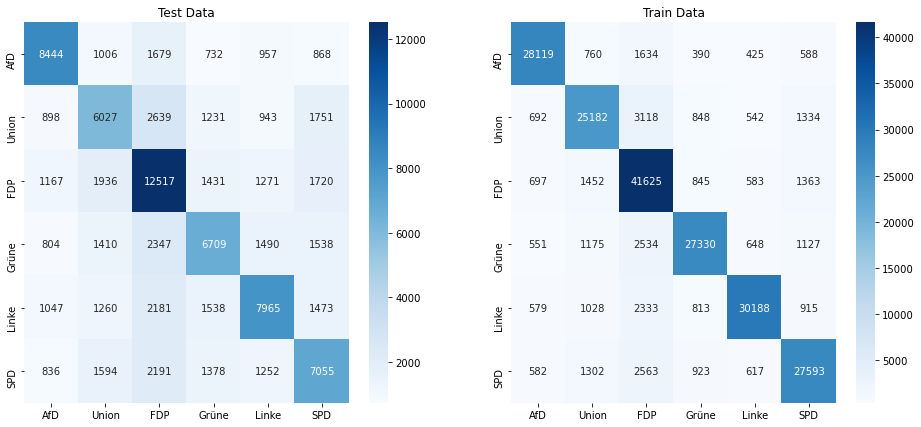

Party: 	 Test 	 Train
Afd:	 13686 	 31916
Union:	 13489 	 31716
FDP:	 20042 	 46565
Grüne:	 14298 	 33365
Linke:	 15464 	 35856
SPD:	 14306 	 33580

Acc:	 53.37% 84.53%

              precision    recall  f1-score   support

           0     0.6399    0.6170    0.6282     13686
           1     0.4555    0.4468    0.4511     13489
           2     0.5314    0.6245    0.5742     20042
           3     0.5153    0.4692    0.4912     14298
           4     0.5739    0.5151    0.5429     15464
           5     0.4898    0.4931    0.4914     14306

    accuracy                         0.5337     91285
   macro avg     0.5343    0.5276    0.5298     91285
weighted avg     0.5346    0.5337    0.5328     91285



In [10]:
# Loading and analyzing the trained model
svc_model_cnt_lem = load('pipe_svc_cnt_lem.joblib') 
print("Report for the LinearSVC model with CountVectorizer and lemmatization")
plot_confusion_matrix(svc_model_cnt_lem, X_train, X_test, y_train, y_test)

In [8]:
# Using lemmatization. Make pipeline with TfidfVectorizer and LinearSVC classifier
pipe_tfidf_cnt_lem = make_pipeline(TfidfVectorizer(tokenizer=spacy_tokenizer), LinearSVC(max_iter=10000, dual=False), True)
pipe_tfidf_cnt_lem.fit(X_train, y_train)
dump(pipe_tfidf_cnt_lem, 'pipe_tfidf_cnt_lem.joblib')

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=27.4min
[Pipeline] ............. (step 2 of 2) Processing model, total= 1.1min


['pipe_tfidf_cnt_lem.joblib']

Report for the LinearSVC model with TFidfVectorizer and lemmatization


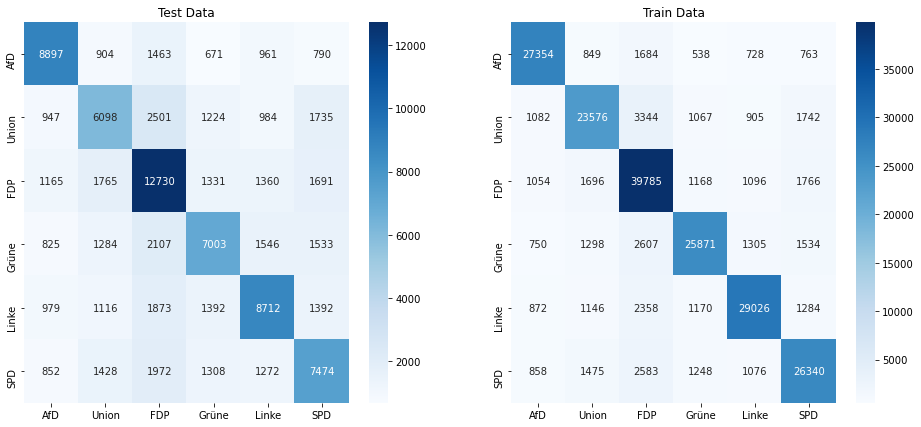

Party: 	 Test 	 Train
Afd:	 13686 	 31916
Union:	 13489 	 31716
FDP:	 20042 	 46565
Grüne:	 14298 	 33365
Linke:	 15464 	 35856
SPD:	 14306 	 33580

Acc:	 55.77% 80.73%

              precision    recall  f1-score   support

           0     0.6511    0.6501    0.6506     13686
           1     0.4842    0.4521    0.4676     13489
           2     0.5621    0.6352    0.5964     20042
           3     0.5417    0.4898    0.5144     14298
           4     0.5873    0.5634    0.5751     15464
           5     0.5114    0.5224    0.5169     14306

    accuracy                         0.5577     91285
   macro avg     0.5563    0.5522    0.5535     91285
weighted avg     0.5570    0.5577    0.5566     91285



In [9]:
# Loading and analyzing the trained model
pipe_svc_tfidf_lem = load('pipe_tfidf_cnt_lem.joblib')
print("Report for the LinearSVC model with TFidfVectorizer and lemmatization")
plot_confusion_matrix(pipe_svc_tfidf_lem, X_train, X_test, y_train, y_test)

In [13]:
# Creating pipelines for the CountVectorizer and various classifiers
pipe_svc_cnt = make_pipeline(CountVectorizer(), LinearSVC(max_iter=10000, dual=False), True)
pipe_lg_cnt = make_pipeline(CountVectorizer(), 
                            LogisticRegression(max_iter=10000, solver='lbfgs', dual=False, random_state=0), True)
pipe_nb_cnt = make_pipeline(CountVectorizer(), MultinomialNB(), True)

In [12]:
pipe_svc_cnt.fit(X_train, y_train)
dump(pipe_svc_cnt, 'pipe_svc_cnt.joblib')

pipe_lg_cnt.fit(X_train, y_train)
dump(pipe_lg_cnt, 'pipe_lg_cnt.joblib')

pipe_nb_cnt.fit(X_train, y_train)
dump(pipe_nb_cnt, 'pipe_nb_cnt.joblib')

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   5.2s
[Pipeline] ............. (step 2 of 2) Processing model, total=12.8min
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   6.5s
[Pipeline] ............. (step 2 of 2) Processing model, total= 9.3min
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   4.2s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


['pipe_nb_cnt.joblib']

In [14]:
# Creating pipelines for the TfidfVectorizer and various classifiers
pipe_svc_tfidf = make_pipeline(TfidfVectorizer(), LinearSVC(max_iter=10000, dual=False), True)
pipe_lg_tfidf = make_pipeline(TfidfVectorizer(), 
                            LogisticRegression(max_iter=10000, solver='lbfgs', dual=False, random_state=0), True)
pipe_nb_tfidf = make_pipeline(TfidfVectorizer(), MultinomialNB(), True)

In [15]:
pipe_svc_tfidf.fit(X_train,y_train)
dump(pipe_svc_tfidf, 'pipe_svc_tfidf.joblib')

pipe_lg_tfidf.fit(X_train,y_train)
dump(pipe_lg_tfidf, 'pipe_lg_tfidf.joblib')

pipe_nb_tfidf.fit(X_train,y_train)
dump(pipe_nb_tfidf, 'pipe_nb_tfidf.joblib')

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   4.2s
[Pipeline] ............. (step 2 of 2) Processing model, total=  58.5s
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   4.3s
[Pipeline] ............. (step 2 of 2) Processing model, total= 3.7min
[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=   4.3s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


['pipe_nb_tfidf.joblib']

Report for the LinearSVC model with CountVectorizer


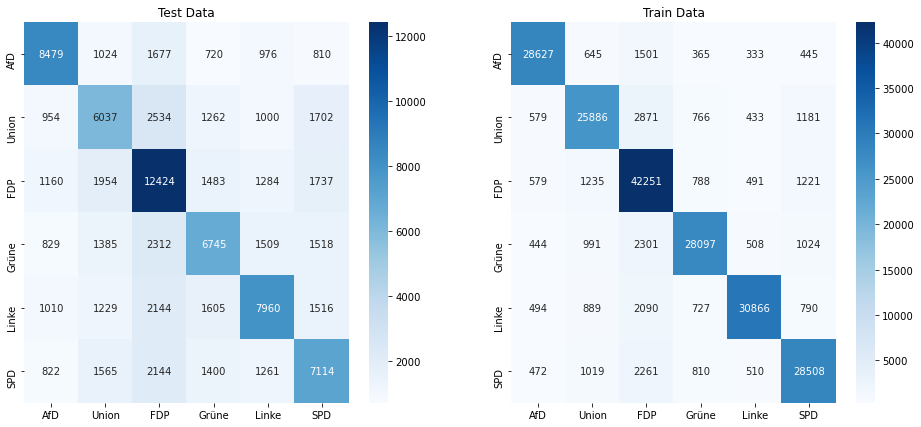

Party: 	 Test 	 Train
Afd:	 13686 	 31916
Union:	 13489 	 31716
FDP:	 20042 	 46565
Grüne:	 14298 	 33365
Linke:	 15464 	 35856
SPD:	 14306 	 33580

Acc:	 53.41% 86.50%

              precision    recall  f1-score   support

           0     0.6397    0.6195    0.6295     13686
           1     0.4576    0.4475    0.4525     13489
           2     0.5347    0.6199    0.5742     20042
           3     0.5104    0.4717    0.4903     14298
           4     0.5690    0.5147    0.5405     15464
           5     0.4941    0.4973    0.4957     14306

    accuracy                         0.5341     91285
   macro avg     0.5343    0.5285    0.5304     91285
weighted avg     0.5347    0.5341    0.5333     91285

Report for the LinearSVC model with TfIdfVectorizer


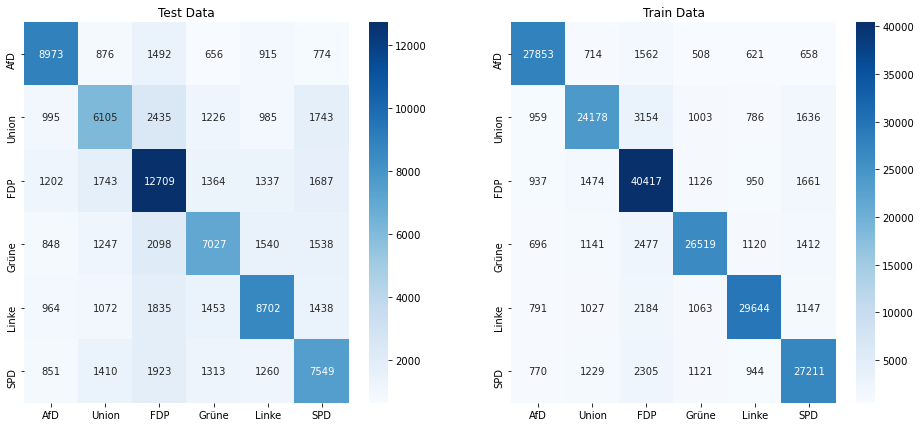

Party: 	 Test 	 Train
Afd:	 13686 	 31916
Union:	 13489 	 31716
FDP:	 20042 	 46565
Grüne:	 14298 	 33365
Linke:	 15464 	 35856
SPD:	 14306 	 33580

Acc:	 55.94% 82.55%

              precision    recall  f1-score   support

           0     0.6487    0.6556    0.6521     13686
           1     0.4902    0.4526    0.4707     13489
           2     0.5650    0.6341    0.5976     20042
           3     0.5389    0.4915    0.5141     14298
           4     0.5904    0.5627    0.5762     15464
           5     0.5125    0.5277    0.5200     14306

    accuracy                         0.5594     91285
   macro avg     0.5576    0.5540    0.5551     91285
weighted avg     0.5585    0.5594    0.5582     91285



In [16]:
# Comparison of results for CountVectorizer and TfIdfVectorizer for LinearSVC classifier
svc_model_cnt = load('pipe_svc_cnt.joblib')
print("Report for the LinearSVC model with CountVectorizer")
plot_confusion_matrix(svc_model_cnt, X_train, X_test, y_train, y_test)
svc_model_tfidf = load('pipe_svc_tfidf.joblib')
print("Report for the LinearSVC model with TfIdfVectorizer")
plot_confusion_matrix(svc_model_tfidf, X_train, X_test, y_train, y_test)

Report for the LogisticRegression model with CountVectorizer


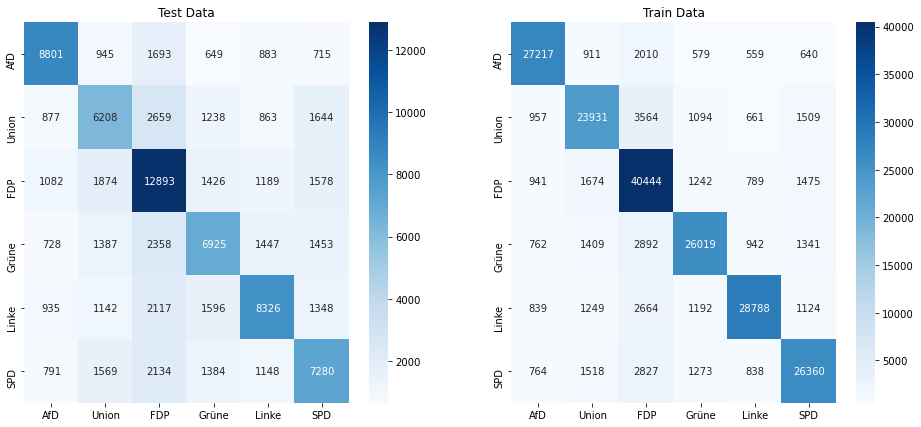

Party: 	 Test 	 Train
Afd:	 13686 	 31916
Union:	 13489 	 31716
FDP:	 20042 	 46565
Grüne:	 14298 	 33365
Linke:	 15464 	 35856
SPD:	 14306 	 33580

Acc:	 55.25% 81.11%

              precision    recall  f1-score   support

           0     0.6660    0.6431    0.6543     13686
           1     0.4730    0.4602    0.4665     13489
           2     0.5405    0.6433    0.5874     20042
           3     0.5239    0.4843    0.5033     14298
           4     0.6009    0.5384    0.5679     15464
           5     0.5193    0.5089    0.5141     14306

    accuracy                         0.5525     91285
   macro avg     0.5539    0.5464    0.5489     91285
weighted avg     0.5537    0.5525    0.5516     91285

Report for the LogisticRegression model with TfIdfVectorizer


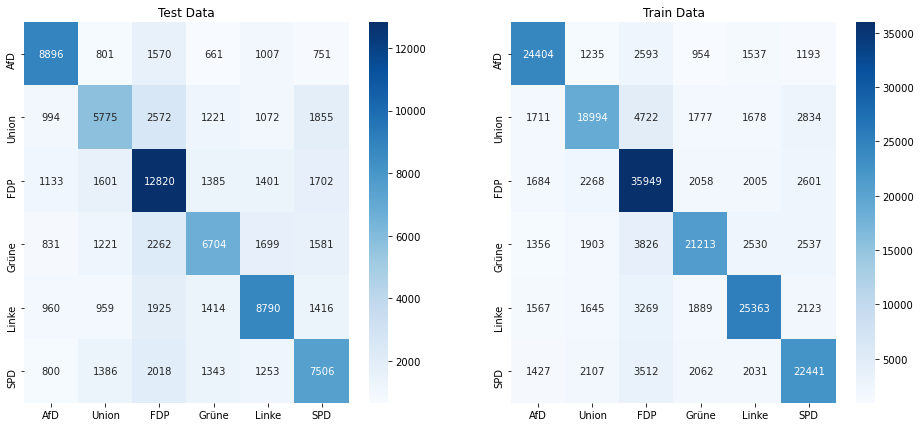

Party: 	 Test 	 Train
Afd:	 13686 	 31916
Union:	 13489 	 31716
FDP:	 20042 	 46565
Grüne:	 14298 	 33365
Linke:	 15464 	 35856
SPD:	 14306 	 33580

Acc:	 55.31% 69.66%

              precision    recall  f1-score   support

           0     0.6534    0.6500    0.6517     13686
           1     0.4918    0.4281    0.4578     13489
           2     0.5534    0.6397    0.5934     20042
           3     0.5267    0.4689    0.4961     14298
           4     0.5775    0.5684    0.5729     15464
           5     0.5068    0.5247    0.5156     14306

    accuracy                         0.5531     91285
   macro avg     0.5516    0.5466    0.5479     91285
weighted avg     0.5519    0.5531    0.5512     91285



In [17]:
# Comparison of results for CountVectorizer and TfIdfVectorizer for LogisticRegression classifier
lg_model_cnt = load('pipe_lg_cnt.joblib')
print("Report for the LogisticRegression model with CountVectorizer")
plot_confusion_matrix(lg_model_cnt, X_train, X_test, y_train, y_test)
lg_model_tfidf = load('pipe_lg_tfidf.joblib')
print("Report for the LogisticRegression model with TfIdfVectorizer")
plot_confusion_matrix(lg_model_tfidf, X_train, X_test, y_train, y_test)

Report for the MultinomialNB model with CountVectorizer


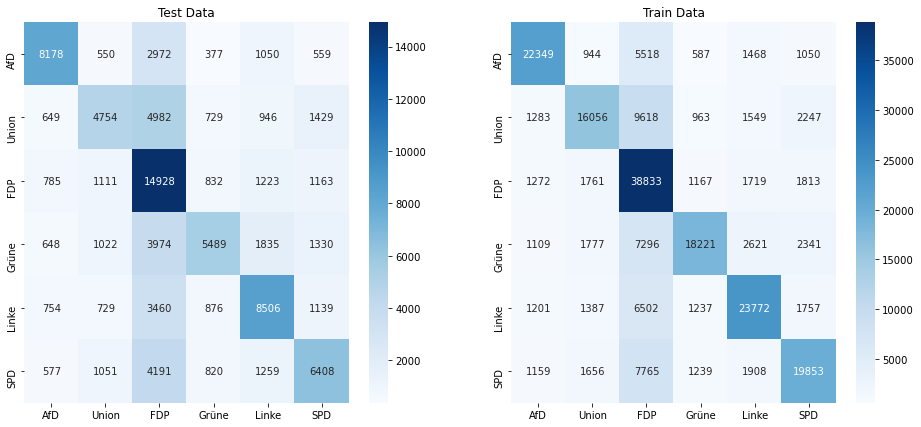

Party: 	 Test 	 Train
Afd:	 13686 	 31916
Union:	 13489 	 31716
FDP:	 20042 	 46565
Grüne:	 14298 	 33365
Linke:	 15464 	 35856
SPD:	 14306 	 33580

Acc:	 52.87% 65.30%

              precision    recall  f1-score   support

           0     0.7055    0.5975    0.6471     13686
           1     0.5158    0.3524    0.4187     13489
           2     0.4326    0.7448    0.5473     20042
           3     0.6017    0.3839    0.4687     14298
           4     0.5740    0.5501    0.5618     15464
           5     0.5328    0.4479    0.4867     14306

    accuracy                         0.5287     91285
   macro avg     0.5604    0.5128    0.5217     91285
weighted avg     0.5519    0.5287    0.5239     91285

Report for the MultinomialNB model with TfIdfVectorizer


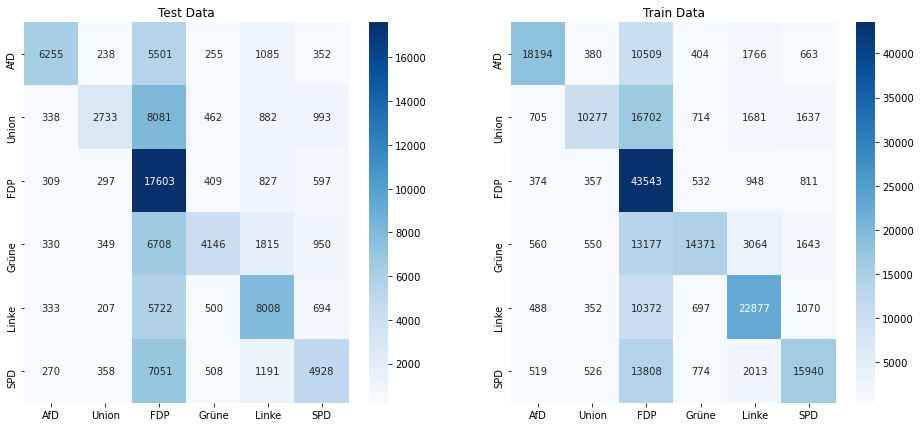

Party: 	 Test 	 Train
Afd:	 13686 	 31916
Union:	 13489 	 31716
FDP:	 20042 	 46565
Grüne:	 14298 	 33365
Linke:	 15464 	 35856
SPD:	 14306 	 33580

Acc:	 47.84% 58.78%

              precision    recall  f1-score   support

           0     0.7983    0.4570    0.5813     13686
           1     0.6535    0.2026    0.3093     13489
           2     0.3474    0.8783    0.4979     20042
           3     0.6602    0.2900    0.4030     14298
           4     0.5800    0.5178    0.5471     15464
           5     0.5788    0.3445    0.4319     14306

    accuracy                         0.4784     91285
   macro avg     0.6030    0.4484    0.4618     91285
weighted avg     0.5849    0.4784    0.4657     91285



In [18]:
# Comparison of results for CountVectorizer and TfIdfVectorizer for MultinomialNB classifier
nb_model_cnt = load('pipe_nb_cnt.joblib')
print("Report for the MultinomialNB model with CountVectorizer")
plot_confusion_matrix(nb_model_cnt, X_train, X_test, y_train, y_test)
nb_model_tfidf = load('pipe_nb_tfidf.joblib')
print("Report for the MultinomialNB model with TfIdfVectorizer")
plot_confusion_matrix(nb_model_tfidf, X_train, X_test, y_train, y_test)